In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import chic

from astropy import units as u
from astropy import constants as C
from astropy.cosmology import Planck18
from tqdm.auto import tqdm

## Problem 1

### Part 1

My code from last homework is not really in the shape we need for this problem, so below I have rewritten it in a better form.

Ultimately, we need a function `electron_fraction` which computes $x_e$ given $z$, including hydrogen and helium recombinations.

In [8]:
from scipy.integrate import solve_ivp

E_I = 13.6 * u.eV
E_21 = 10.2 * u.eV
E_1 = 24.59 * u.eV
E_2 = 54.42 * u.eV

m_e = (C.m_e * C.c**2).to(u.eV)
m_p = (C.m_p * C.c**2).to(u.eV)
m_H_0 = (m_p + m_e - E_I)
m_He_0 = 4.002602 * (C.u * C.c**2).to(u.eV)
m_He_1 = E_1 + m_He_0 - m_e
m_He_2 = E_2 + m_He_1 - m_e

m_e_tilde = (m_p / m_H_0) * m_e
m_e_tilde1 = m_He_1 / m_He_0 * m_e
m_e_tilde2 = m_He_2 / m_He_1 * m_e

sigma_T = 6.65e-25 * u.cm**2  # Thomson scattering cross section

lambda_21 = (C.h * C.c / E_21).to(u.Angstrom)
Lambda_2g = 8.22 / u.s

def helium_fraction(Y_He):
    ratio = (m_p / m_He_0).to(u.dimensionless_unscaled).value
    return ratio / (1 / Y_He - 1)

def A_B(T: u.Quantity['energy']):
    T4 = T / (1e4 * u.K * C.k_B)
    T4 = T4.to(u.dimensionless_unscaled).value
    return (
        (4.309 * np.pow(T4, -0.6166))
        / (1 + 0.6703 * np.pow(T4, 0.53))
        * (1e-13 * u.cm**3 / u.s)
    )

def saha_equilibrium_RHS(T: u.Quantity['energy'], n_H: u.Quantity['number density']):
    E_over_T = (E_I / T).to(u.dimensionless_unscaled).value
    n_H_eV = (n_H * (C.c * C.hbar)**3).to(u.eV**3)
    eV3_ratio = ((m_e_tilde * T) / (2 * np.pi))**(3/2) / n_H_eV
    eV3_ratio = eV3_ratio.to(u.dimensionless_unscaled).value
    RHS = eV3_ratio * np.exp(-E_over_T)
    return RHS

def peebles_C(T: u.Quantity['energy'], n_H: u.Quantity['number density'], H: u.Quantity['frequency'] = 67.6 * u.km/u.s/u.Mpc):
    E21_over_T = (E_21 / T).to(u.dimensionless_unscaled).value
    _A_B = A_B(T)
    x_eq_RHS = saha_equilibrium_RHS(T, n_H)
    numer = (8 * np.pi * H) / (lambda_21**3 * n_H).to(u.dimensionless_unscaled).value + Lambda_2g
    four_B_B = n_H * _A_B * np.exp(E21_over_T) * x_eq_RHS
    return (numer / (numer + four_B_B)).to(u.dimensionless_unscaled).value

threshold = 1e6

def helium_I(T, f_He, n_H):
    E_over_T = (E_1 / T).to(u.dimensionless_unscaled).value
    n_H_eV = (n_H * (C.c * C.hbar)**3).to(u.eV**3)
    RHS = (m_e_tilde1 * T / (2 * np.pi))**(3/2) / n_H_eV * np.exp(-E_over_T)
    RHS = RHS.to(u.dimensionless_unscaled).value

    if RHS > threshold:
        return 1 + f_He
    elif RHS < 1 / threshold:
        return 1
    else:
        return 0.5 * (1 - RHS + np.sqrt((1 + RHS)**2 + 4 * f_He * RHS))

def helium_II(T, f_He, n_H):
    E_over_T = (E_2 / T).to(u.dimensionless_unscaled).value
    n_H_eV = (n_H * (C.c * C.hbar)**3).to(u.eV**3)
    RHS = (m_e_tilde2 * T / (2 * np.pi))**(3/2) / n_H_eV * np.exp(-E_over_T)
    RHS = RHS.to(u.dimensionless_unscaled).value
    if RHS > threshold:
        return 1 + 2 * f_He
    elif RHS < 1 / threshold:
        return 1 + f_He
    else:
        return 0.5 * (1 - RHS + f_He + np.sqrt((1 + RHS + f_He)**2 + 4 * f_He * RHS))

class RecombinationSolver:
    def __init__(self):
        self.O_b = Planck18.Ob0
        self.O_m = Planck18.Om0
        self.O_L = Planck18.Ode0
        self.O_r = 1 - self.O_m - self.O_L
        
        self.H_0 = Planck18.H0
        self.h = self.H_0 / (100 * u.km/u.s/u.Mpc)
        self.h = self.h.to(u.dimensionless_unscaled).value

        self.N_eff = Planck18.Neff
        self.Y_He = 0.24
        self.f_He = helium_fraction(self.Y_He)
        self.T_0 = (Planck18.Tcmb0 * C.k_B).to(u.eV)
        
        self.omega_b = self.O_b * self.h**2
        self.n_H_0 = (
            (self.O_b * Planck18.critical_density0)
            / ((m_p + helium_fraction(self.Y_He) * m_He_0) / C.c**2)
        ).to(1 / u.m**3)
    
    def hydrogen_ndensity(self, z):
        return self.n_H_0 * (1 + z)**3

    def hubble(self, z):
        return self.H_0 * np.sqrt(
            self.O_m * (1 + z)**3
            + self.O_r * (1 + z)**4
            + self.O_L
        )

    def temperature(self, z):
        return (1 + z) * self.T_0

    def saha(self, z):
        eq_RHS = saha_equilibrium_RHS(self.temperature(z), self.hydrogen_ndensity(z))
        return 0.5 * (np.sqrt(eq_RHS**2 + 4 * eq_RHS) - eq_RHS)

    def x_e_dot(self, x_e, T, H, n_H):
        _A = A_B(T)
        _C = peebles_C(T, n_H, H)
        saha = saha_equilibrium_RHS(T, n_H)
        return - _C * n_H * _A * (x_e**2 - saha * (1 - x_e))

    def dxe_dz(self, z, x_e):
        _T = self.temperature(z)
        _H = self.hubble(z)
        _n_H = self.hydrogen_ndensity(z)
        _x_e_dot = self.x_e_dot(x_e, _T, _H, _n_H)
        _output = - (_x_e_dot / ((1 + z) * self.hubble(z)))
        _output = _output.to(u.dimensionless_unscaled).value
        return _output

    def solve(self, z_0=1500, z_1=200, z_eval=None):
        x_e_0 = self.saha(z_0)

        result = solve_ivp(
            self.dxe_dz,
            (z_0, z_1),
            np.array([x_e_0]),
            t_eval=z_eval
        )

        if not result.success:
            raise RuntimeError(result.message)

        zs, x_es = result.t, result.y.squeeze()

        return zs, x_es

    def helium_I(self, z):
        return helium_I(
            self.temperature(z),
            self.f_He,
            self.hydrogen_ndensity(z)
        )

    def helium_II(self, z):
        return helium_II(
            self.temperature(z),
            self.f_He,
            self.hydrogen_ndensity(z)
        )

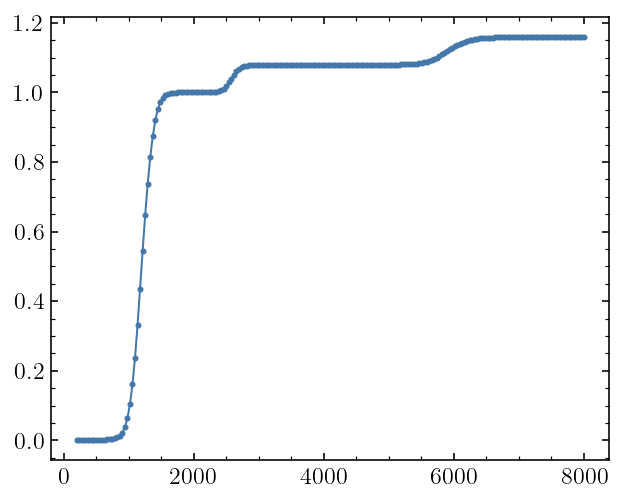

In [46]:
rsolver = RecombinationSolver()

zs = np.linspace(8_000, 200, num=200+1)
done = np.zeros(len(zs), dtype=bool)

# first helium recombination:
x_es = np.array([rsolver.helium_II(z) for z in zs])
# first cutoff:
done |= x_es > (1 + rsolver.f_He)

# second helium recombination
x_e_Is = np.array([rsolver.helium_I(z) for z in zs[~done]])
x_es[~done] = x_e_Is
# second cutoff:
done |= x_es > 1

# hydrogen recombination
H_zs = zs[~done]
z_H, x_e_H = rsolver.solve(z_0 = H_zs[0]+1e-5, z_1 = H_zs[-1]-1e-5, z_eval=H_zs)
x_es[~done] = x_e_H

# plot
plt.plot(zs, x_es, '-o', markersize=2, linewidth=1)

plt.show()

Now, to make a function `electron_fraction` which quickly gets the value of $x_e$ as computed above *without* having to do the full calculation for each individual value of $z$, let's interpolate this function.

In [47]:
from scipy.interpolate import CubicSpline

electron_fraction = CubicSpline(zs[::-1], x_es[::-1])

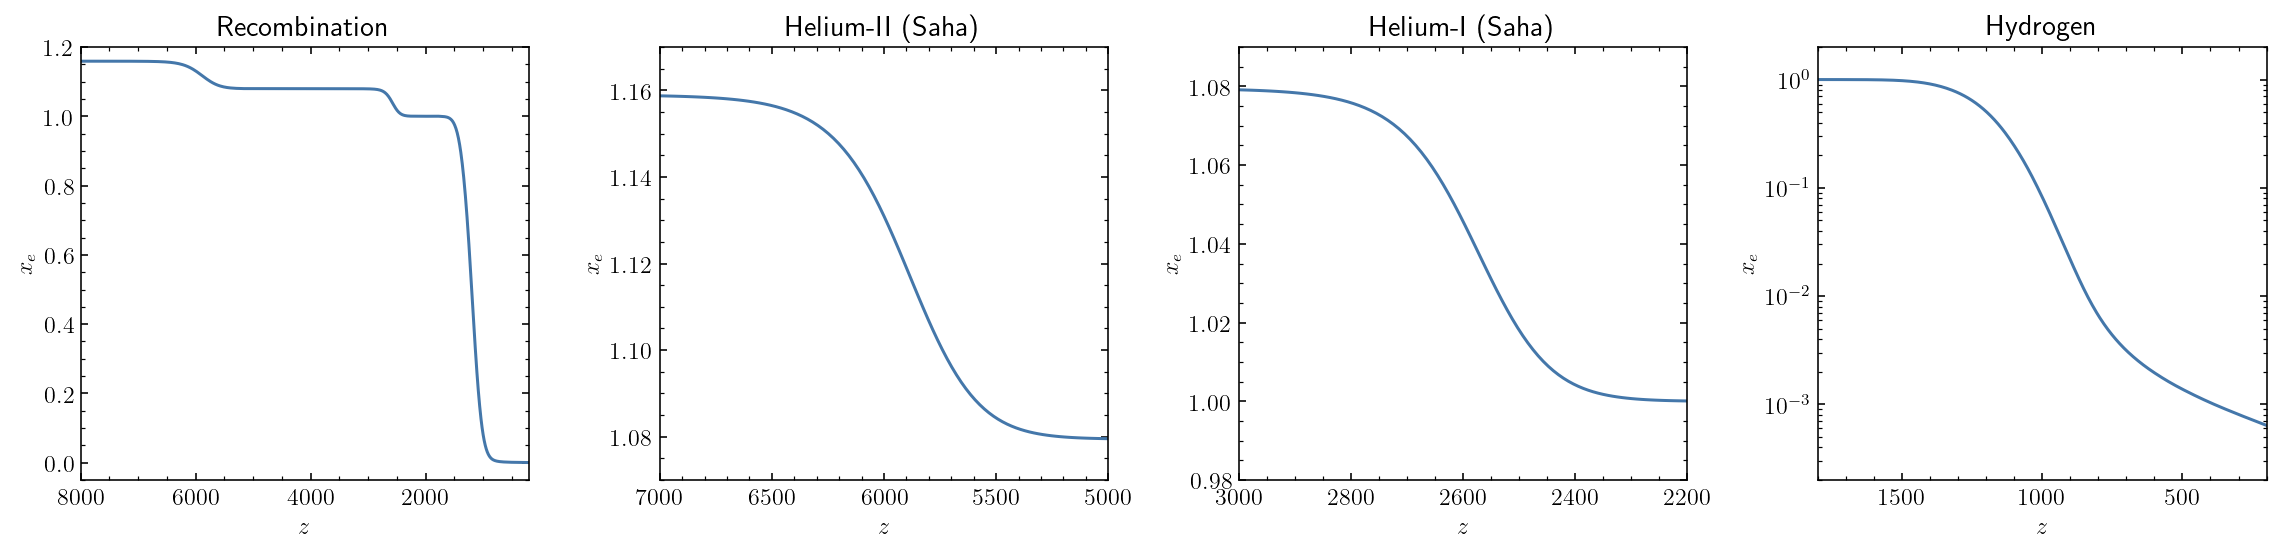

In [54]:
zs = np.geomspace(200, 8000, 1_000+1)
x_es = np.array([electron_fraction(z) for z in zs])

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].plot(zs, x_es)
axs[0].set_xlim(8000, 200)
axs[0].set_ylim(-0.05, 1.2)
axs[0].set_title('Recombination')

axs[1].plot(zs, x_es)
axs[1].set_xlim(7000, 5000)
axs[1].set_ylim(1.07, 1.17)
axs[1].set_title('Helium-II (Saha)')

axs[2].plot(zs, x_es)
axs[2].set_xlim(3000, 2200)
axs[2].set_ylim(0.98, 1.09)
axs[2].set_title('Helium-I (Saha)')

axs[3].plot(zs, x_es)
axs[3].set_xlim(1800, 200)
axs[3].set_ylim(2e-4, 2)
axs[3].set_yscale('log')
axs[3].set_title('Hydrogen')

for ax in axs.flat:
    ax.set_xlabel('$z$')
    ax.set_ylabel('$x_e$')

fig.tight_layout()
plt.show()

Now `electron_fraction` computes $x_e$ given $z$.

We want to compute the visibility function $g$. It's defined
$$
g(\eta) = a \, n_e \, \sigma_T \, \exp \Big[ - \int_{\eta}^{\eta_0} \mathrm{d}\eta' \, a' \, n_e' \, \sigma_T' \Big]
$$
where primes in the exponentiated integral are taken to mean "evaluated at $\eta'$".

Using
$$
\renewcommand{\d}{{\rm d}}
\d\eta
= \frac{\d\eta}{\d t}\, \frac{\d t}{\d a}\, \frac{\d a}{\d z}\, \d z
= \frac{1}{a} \, \frac{1}{\dot{a}} (-a^2) \, \d z
= -\frac{\d z}{H},
$$
we can rewrite everything in terms of $z$ to make use of $x_e(z)$:
$$
g(z) = \frac{n_e(z) \, \sigma_T}{1 + z} \, \exp \Big[ - \int_{0}^{z} \d z'\, \frac{n_e(z') \, \sigma_T}{(1 + z') \, H(z')} \,   \Big]
$$
where
$$
H(z) = H_0 \big[
    \Omega_r \, (1 + z)^4 +
    \Omega_m \, (1 + z)^3 +
    \Omega_\Lambda
\big]^{1/2}
$$
and
$$
n_e(z) = \frac{\Omega_b \, \rho_{{\rm crit}, 0}}{m_p + f_{{\rm He}} \, m_{{\rm He}}} \, (1+z)^3 \, x_e(z)
$$

In [55]:
from scipy.integrate import quad

def visibility(z_arr):
    
    def _integrand(z):
        n_e = rsolver.hydrogen_ndensity(z) * electron_fraction(z)
        out = n_e * sigma_T / ((1 + z) * rsolver.hubble(z))
        return (out * C.c).to(u.dimensionless_unscaled).value

    z_arr = np.atleast_1d(z_arr)
    g_arr = np.zeros_like(z_arr)

    for i, z in enumerate(tqdm(z_arr)):
        n_e = rsolver.hydrogen_ndensity(z) * electron_fraction(z)
        _prefactor = n_e * sigma_T / (1 + z)
        _integral = quad(_integrand, 0, z)[0]
        _value = _prefactor * np.exp(-_integral)
        _value.to(1 / u.Mpc)
        g_arr[i] = _value.value

    return g_arr * (1 / u.Mpc)

  0%|          | 0/500 [00:00<?, ?it/s]

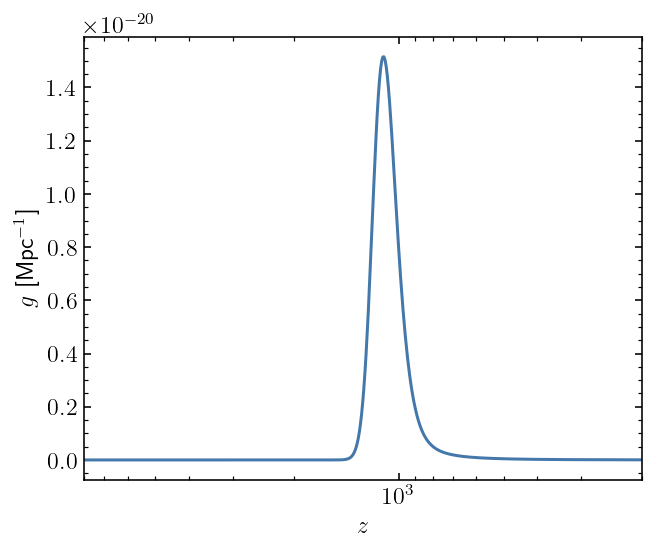

In [59]:
zs = np.geomspace(200, 8_000, 500)
gs = visibility(zs)

plt.plot(zs, gs)
plt.xscale('log')
plt.xlim(8000, 200)
plt.xlabel('$z$')
plt.ylabel('$g$ [Mpc$^{-1}$]')
plt.show()

### Part 3

I found

$$
\newcommand{\He}{{\rm He}}
\begin{aligned}
\tau_{\rm reio}
&= \left(
    \frac{1 - Y_\He}{m_p}
    + \frac{2 \, Y_\He}{m_{ \He^{++} }}
\right)
\frac{2 \, \sigma_{\rm T}}{3\, (100 \ \text{km/s/Mpc}) \sqrt{\omega_m}}
\frac{3 \, (100 \ \text{km/s/Mpc})^2 \, \omega_b}{8 \pi G}
\left[
    \sqrt{ a_{m\Lambda}^{-3} + (1 + z_{\rm reio})^3 }
    - \sqrt{ a_{m\Lambda}^{-3} + 1 }
\right] \\
&= \left(
    \frac{1 - Y_\He}{m_p}
    + \frac{2 \, Y_\He}{m_{ \He^{++} }}
\right)
\frac{2 \, (100 \ \text{km/s/Mpc}) \, \sigma_{\rm T} \, \omega_b}{8 \pi G \, \sqrt{\omega_m}}
\left[
    \sqrt{ a_{m\Lambda}^{-3} + (1 + z_{\rm reio})^3 }
    - \sqrt{ a_{m\Lambda}^{-3} + 1 }
\right]
\end{aligned}
$$

In [2]:
Y_He = 0.24
m_p = (C.m_p * C.c**2).to(u.eV)
m_He = (4.002602 * u.u * C.c**2).to(u.eV)
sigma_T = 6.65e-25 * u.cm**2

little_h = (Planck18.H0/(100 * u.km/u.s/u.Mpc)).to(u.dimensionless_unscaled)

omega_b = (Planck18.Ob0 * little_h**2)
omega_m = (Planck18.Om0 * little_h**2)
omega_L = (Planck18.Ode0 * little_h**2)

a_mL = (omega_m / omega_L)**(1/3)

coeff = (
    ((1 - Y_He) / m_p + 2 * Y_He / m_He)
    * (2 * (100 * u.km/u.s/u.Mpc) * omega_b) / (8 * np.pi * C.G * np.sqrt(omega_m))
    * sigma_T
    * C.c**3
).to(u.dimensionless_unscaled)
print(f"alpha = {coeff:.3e}")

def tau_reio(z_reio):
    return coeff * (np.sqrt( a_mL**-3 + (1 + z_reio)**3 ) - np.sqrt( a_mL**-3 + 1 ))

alpha = 2.415e-03


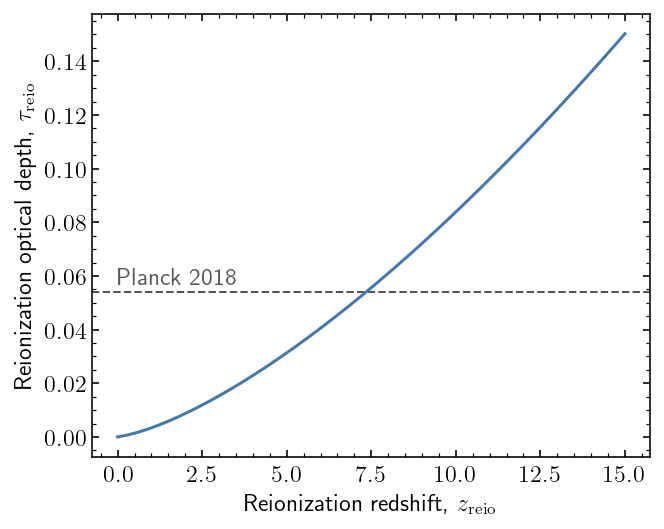

In [3]:
zs = np.linspace(0, 15)

plt.plot(zs, tau_reio(zs), zorder=999)
plt.axhline(0.054, lw=1, ls='--', color='#555')
plt.text(0, 0.054 + 0.003, 'Planck 2018', color='#555')
plt.xlabel('Reionization redshift, $z_{\\rm reio}$')
plt.ylabel('Reionization optical depth, $\\tau_{\\rm reio}$')
plt.show()

I inverted the relationship and got
$$
z_{\rm reio} = \left[
    (\tau_{\rm reio}/\alpha)^2 + 2 \, (\tau_{\rm reio}/\alpha) \, \sqrt{a_{m\Lambda}^{-3} + 1} + 1
\right]^{1/3} - 1
$$
where $\alpha$ is `coeff` from above

this allows us to also do error propagation:
$$
\sigma_z = \frac{\partial z}{\partial \tau} \sigma_\tau
$$

In [5]:
pl_tau = 0.054
pl_sigma_tau = 0.007

z_plus_1_cubed = (pl_tau / coeff)**2 + 2 * (pl_tau / coeff) * np.sqrt(a_mL**-3 + 1) + 1

z_reio = np.power(z_plus_1_cubed, 1/3) - 1
print(f'z_reio: {z_reio:.3f}')

sigma_z = (
    (1/3) * np.power(z_plus_1_cubed, -2/3)
    * (2 * pl_tau / coeff**2 + 2 * np.sqrt(a_mL**-3 + 1) / coeff)
) * pl_sigma_tau
print(f'sigma_z: {sigma_z:.3f}')

z_reio: 7.345
sigma_z: 0.670
